# Processing IRGASON data

This notebook describes my first stab at computing turbulent fluxes by eddy-covariance from IRGASON 3-d velocities at 20 Hz.

In [1]:
from asist.irgason import read_irgason_from_netcdf
from asist_nsf_2018.experiments import experiments
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams.update({'font.size': 16})

IRGASON_DATA_PATH = os.environ['IRGASON_DATA_PATH']

## Reading experiment metadata

This will give us the start and end times for each run and fan values.
For the time being I will focus only on the wind-only, freshwater experiment.

In [2]:
#exp_name = 'asist-flow-distortion'
exp_name = 'asist-windonly-fresh'
exp = experiments[exp_name]

In [3]:
data = read_irgason_from_netcdf(IRGASON_DATA_PATH + '/irgason_' + exp_name + '.nc')
t, u, v, w, fan, flag = data['time'], data['u'], data['v'], data['w'], data['fan'], data['flag']

## Raw, unprocessed velocities

### Along-tank velocity $u$

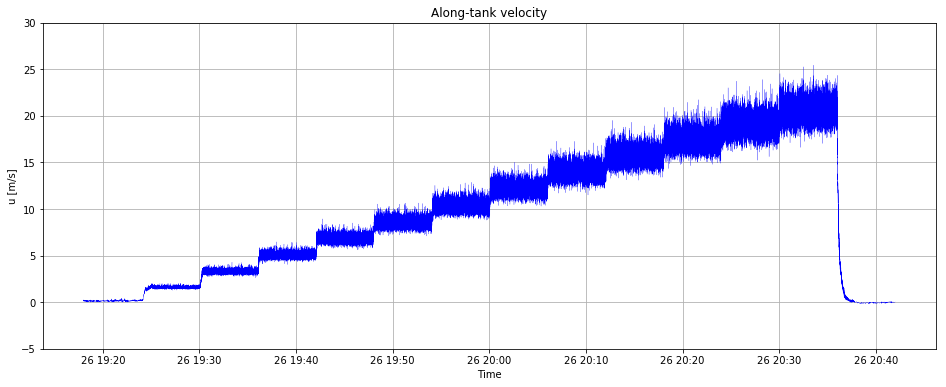

In [4]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, u, 'b-', lw=0.2)
plt.ylim(-5, 30)
plt.xlabel('Time')
plt.ylabel('u [m/s]')
plt.title('Along-tank velocity')
plt.grid()

### Cross-tank velocity $v$

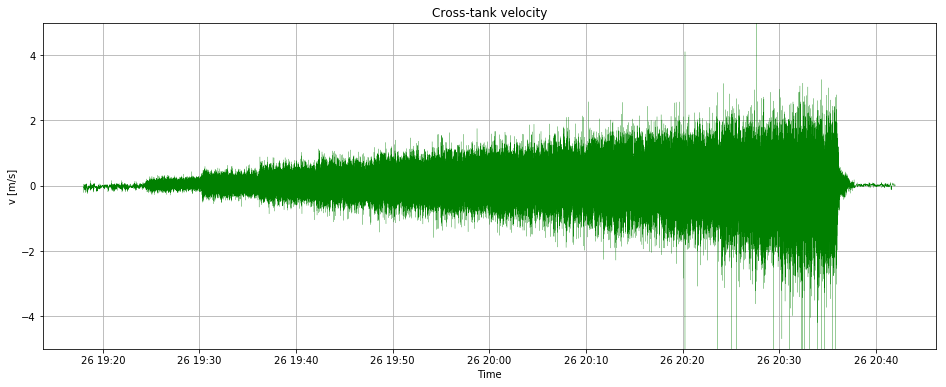

In [5]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, v, 'g-', lw=0.2)
plt.ylim(-5, 5)
plt.xlabel('Time')
plt.ylabel('v [m/s]')
plt.title('Cross-tank velocity')
plt.grid()

### Vertical velocity $w$

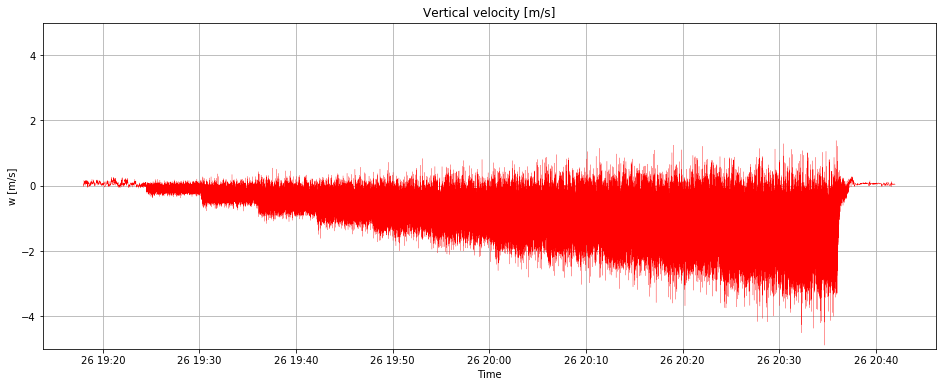

In [6]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, w, 'r-', lw=0.2)
plt.ylim(-5, 5)
plt.xlabel('Time')
plt.ylabel('w [m/s]')
plt.title('Vertical velocity [m/s]')
plt.grid()

## Cleaning some outliers in the data

We can do some preliminary cleaning of the data by limiting the values to a high and low percentile values:

In [7]:
def clean_by_percentile(x, plow, phigh):
    """Limits the values of x to low and high percentile limits."""
    xlow, xhigh = np.percentile(x, plow), np.percentile(x, phigh)
    x[x < xlow] = xlow
    x[x > xhigh] = xhigh
    return x

Minimum and maximum values for $u$, $v$, and $w$:

In [8]:
print('u-velocity range:', np.nanmin(u), np.nanmax(u))
print('v-velocity range:', np.nanmin(v), np.nanmax(v))
print('w-velocity range:', np.nanmin(w), np.nanmax(w))

u-velocity range: -0.1456728 25.43934
v-velocity range: -9.143344 6.381715
w-velocity range: -4.890137 1.38592


To clean the data by percentile range, we need to loop over runs and process the data for each fan setting independently. We'll use experiment metadata to get start and end times from each run and build the mask for the velocity arrays. We then apply the lower and upper limit of 0.1 and 99.9 % to limit the data:

In [9]:
for run in exp.runs[:-1]:
    mask = (t >= run.start_time) & (t <= run.end_time)
    u[mask] = clean_by_percentile(u[mask], 0.1, 99.9)
    v[mask] = clean_by_percentile(v[mask], 0.1, 99.9)
    w[mask] = clean_by_percentile(w[mask], 0.1, 99.9)

In [10]:
print('u-velocity range:', np.min(u), np.max(u))
print('v-velocity range:', np.min(v), np.max(v))
print('w-velocity range:', np.min(w), np.max(w))

u-velocity range: -0.1456728 24.34692
v-velocity range: -6.4297333 2.851321
w-velocity range: -4.1105375 1.21363


## Correcting for the angle of the IRGASON

The instrument is not mounted perfectly. This is due to the imperfections of the steel mount and screws, suction cups, and the mounting process itself. The averaged velocities can tells us about the angle of the IRGASON and how to correct for it.

Some assumptions:

* $\overline v$ should be zero;
* $\overline w$ should be zero;
* IRGASON is correctly mounted in the x-y plane (we will see soon why).

Let's first define a function to calculate the running mean. This is easy with numpy's `convolve` function:

In [11]:
def running_mean(x, n):
    """Running mean of x with the window n."""
    return np.convolve(x, np.ones((n,)) / n, mode='same')

We have 20 records per second, so for a 1-minute running mean we can use a window of 1200:

In [12]:
um = running_mean(u, 1200)
vm = running_mean(v, 1200)
wm = running_mean(w, 1200)

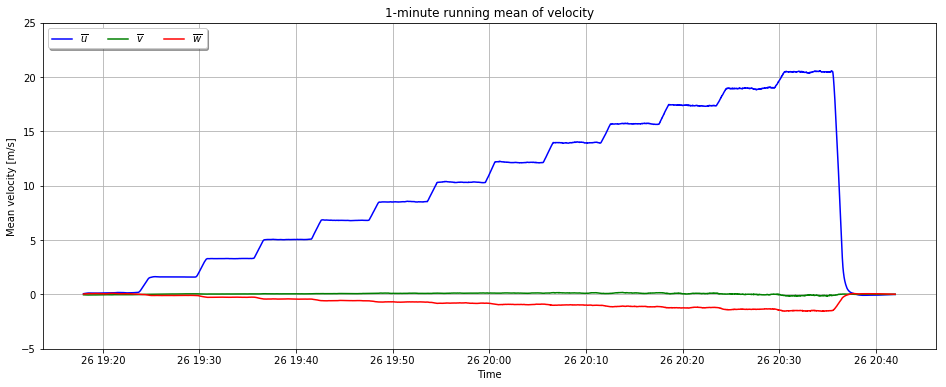

In [13]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, um, 'b-', label=r'$\overline{u}$')
plt.plot(t, vm, 'g-', label=r'$\overline{v}$')
plt.plot(t, wm, 'r-', label=r'$\overline{w}$')
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=3)
plt.ylim(-5, 25)
plt.xlabel('Time')
plt.ylabel('Mean velocity [m/s]')
plt.title('1-minute running mean of velocity')
plt.grid()

It looks like the vertical velocity has a mean negative component that increases with fan setting. It seems like $\overline{u}$ and $\overline{w}$ are correlated:

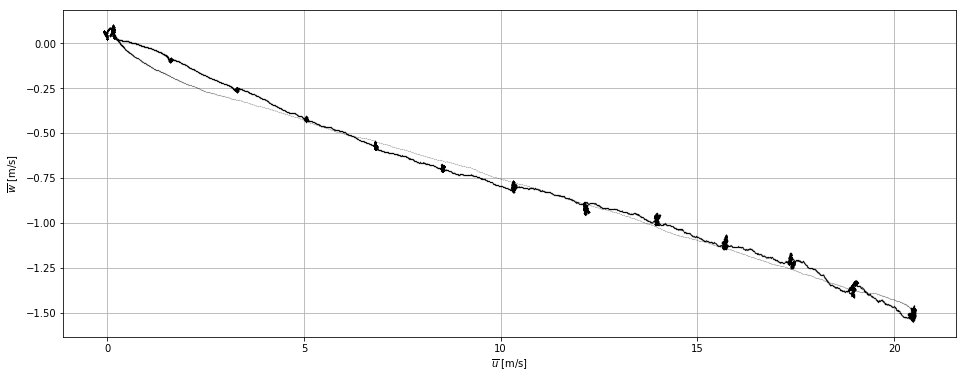

In [14]:
fig = plt.figure(figsize=(16, 6))
plt.plot(um, wm, 'k.', ms=0.1)
plt.xlabel(r'$\overline{u}$ [m/s]')
plt.ylabel(r'$\overline{w}$ [m/s]')
plt.grid()

The angle of the x-axis of the IRGASON body relative to the x-axis of the tank is the arctangent of the mean vertical and horizontal velocities:

In [15]:
th = np.arctan2(wm, um)

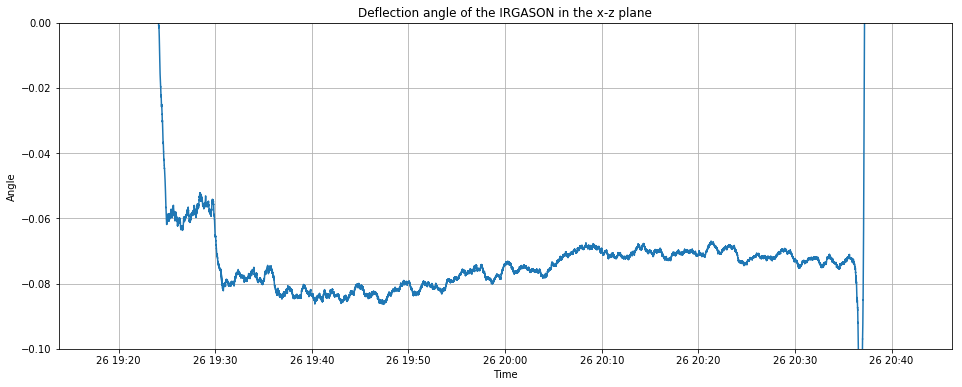

In [16]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, th)
plt.ylim(-0.1, 0)
plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Deflection angle of the IRGASON in the x-z plane')
plt.grid()

In [17]:
def rotate(u, w, th):
    """Rotates the vector (u, w) by angle th."""
    ur =  np.cos(th) * u + np.sin(th) * w
    wr = -np.sin(th) * u + np.cos(th) * w
    return ur, wr

In [18]:
ur, wr = rotate(u, w, th)

In [19]:
urm = running_mean(ur, 1200)
wrm = running_mean(wr, 1200)

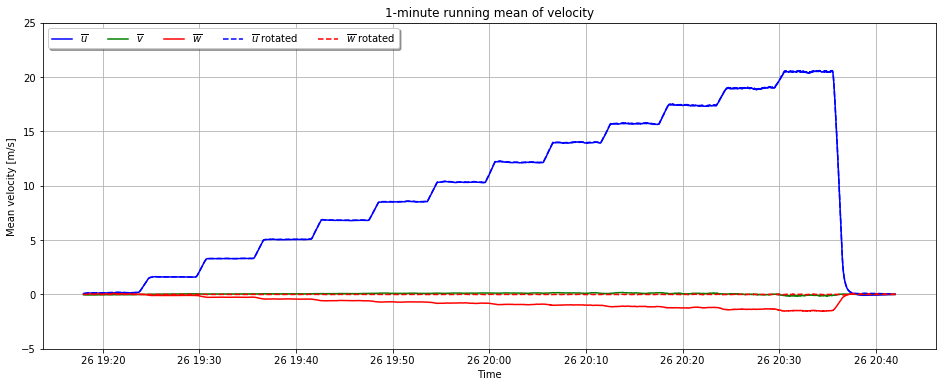

In [20]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, um, 'b-', label=r'$\overline{u}$')
plt.plot(t, vm, 'g-', label=r'$\overline{v}$')
plt.plot(t, wm, 'r-', label=r'$\overline{w}$')
plt.plot(t, urm, 'b--', label=r'$\overline{u}$ rotated')
plt.plot(t, wrm, 'r--', label=r'$\overline{w}$ rotated')
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=5)
plt.ylim(-5, 25)
plt.xlabel('Time')
plt.ylabel('Mean velocity [m/s]')
plt.title('1-minute running mean of velocity')
plt.grid()

In [21]:
up = ur - urm
wp = wr - wrm

In [22]:
uw = []
umean = []
for run in exp.runs[1:-1]:
    mask = (t > run.start_time + timedelta(seconds=60)) & (t < run.end_time - timedelta(seconds=60))
    umean.append(np.mean(u[mask]))
    uw.append(np.mean(up[mask] * wp[mask]))

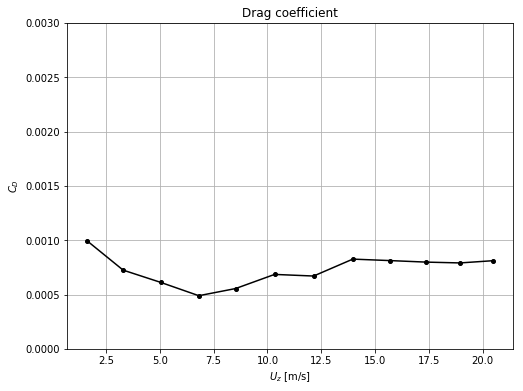

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(umean, uw / np.array(umean)**2, 'k-')
plt.plot(umean, uw / np.array(umean)**2, 'k.', ms=8)
plt.ylim(0, 3e-3)
plt.xlabel(r'$U_z$ [m/s]')
plt.ylabel(r'$C_D$')
plt.title('Drag coefficient')
plt.grid(True)

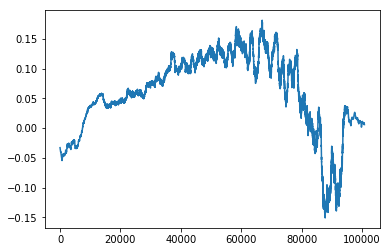

In [25]:
plt.plot(vm)

In [26]:
fan

masked_array(data=[0., 0., 0., ..., 0., 0., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [27]:
fan.size

100801

In [28]:
vm.size

100801

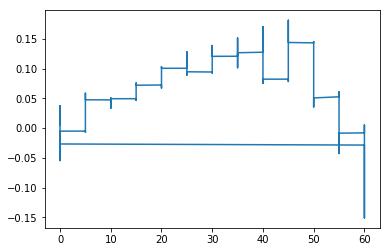

In [29]:
plt.plot(fan, vm)